## Step 0: Setup and Environment

First, we install the required Python libraries and import them. We also clean up any old database files from previous runs to ensure a fresh start.

In [1]:
# !uv add duckdb pandas matplotlib seaborn sqlalchemy psycopg

In [2]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import glob

print("Cleaning up old database files...")
Path("data/homework.db").unlink(missing_ok=True)
Path("data/homework.db.wal").unlink(missing_ok=True)
Path("data/services_all.parquet").unlink(missing_ok=True)

data_dir = Path("data")
data_dir.mkdir(exist_ok=True)

sns.set_theme(style="whitegrid")
print("Setup complete.")

Cleaning up old database files...
Setup complete.


## Step 1: Download Data

In [3]:
# %%bash
# mkdir -p data
#
# echo "Downloading distances..."
# wget https://opendata.rijdendetreinen.nl/public/tariff-distances/tariff-distances-2022-01.csv -O data/station-distances-2022.csv
#
# echo "Downloading stations..."
# wget https://opendata.rijdendetreinen.nl/public/stations/stations-2023-09.csv -O data/stations-2023.csv
#
# echo "Downloading disruptions (2011-2023)..."
# for year in $(seq 2011 2023); do
#   echo "Downloading disruptions for $year"
#   wget https://opendata.rijdendetreinen.nl/public/disruptions/disruptions-$year.csv -O data/disruptions-$year.csv
# done
#
# echo "Downloading services (2019-2022 yearly)..."
# for year in $(seq 2019 2022); do
#   echo "Downloading services for $year"
#   wget https://opendata.rijdendetreinen.nl/public/services/services-$year.csv.gz -O data/services-$year.csv.gz
# done
#
# echo "Downloading services (2023 monthly)..."
# for month in $(seq -w 01 12); do
#   echo "Downloading services for 2023-$month"
#   wget https://opendata.rijdendetreinen.nl/public/services/services-2023-$month.csv.gz -O data/services-2023-$month.csv.gz
# done
#
# echo "Downloading services (2024 monthly)..."
# for month in $(seq -w 01 12); do
#   echo "Downloading services for 2024-$month"
#   wget https://opendata.rijdendetreinen.nl/public/services/services-2024-$month.csv.gz -O data/services-2024-$month.csv.gz
# done
#
# echo "Downloading services (2025 monthly)..."
# for month in $(seq -w 01 09); do
#   echo "Downloading services for 2025-$month"
#   wget https://opendata.rijdendetreinen.nl/public/services/services-2025-0$month.csv.gz -O data/services-2025-$month.csv.gz
# done
#
# echo "All downloads complete."

## Step 2: Create 'stations' table in DuckDB

In [4]:
con = duckdb.connect("data/homework.db")

con.sql("""
CREATE OR REPLACE TABLE stations AS
FROM read_csv(
    'data/stations-2023.csv',
    header=true,
    auto_detect=true
);
""")

## Step 3: Create 'distances' and 'distances_long' tables

In [5]:
# The 'station-distances-2022.csv' file is a WIDE MATRIX, not a LONG 3-column list.
# We will use pandas to unpivot it, as it's simpler than the complex UNPIVOT SQL.

df_wide = pd.read_csv("data/station-distances-2022.csv")

df_long = df_wide.melt(
    id_vars=["Station"],
    var_name="To",
    value_name="Distance",
)

df_long = df_long.rename(columns={"Station": "From"})

df_long = df_long.query("Distance != 'XXX'").copy()

df_long["Distance"] = pd.to_numeric(df_long["Distance"])

print(f"Successfully unpivoted matrix into {len(df_long)} rows.")

con.register("pandas_distances_view", df_long)

con.sql("""
    CREATE OR REPLACE TABLE distances AS
    SELECT * FROM pandas_distances_view;
    """)

con.sql("""
    CREATE OR REPLACE TABLE distances_long AS
    (
        SELECT "From" AS from_station_code,
               "To" AS to_station_code,
               "Distance" AS distance
        FROM distances
    )
    UNION ALL
    (
        SELECT "To" AS from_station_code,
               "From" AS to_station_code,
               "Distance" AS distance
        FROM distances
    );
    """)

Successfully unpivoted matrix into 158802 rows.


## Step 4: Load 'disruptions' into Postgres

In [6]:
con.sql("INSTALL postgres; LOAD postgres;")


con.sql(
    f"ATTACH IF NOT EXISTS 'dbname=postgres user=postgres host=localhost password=postgres' AS pg_db (TYPE postgres);"
)


con.sql("DROP TABLE IF EXISTS pg_db.disruptions;")

disruption_files = glob.glob("data/disruptions-*.csv")

con.sql(f"""
CREATE TABLE pg_db.disruptions AS
FROM read_csv(
    {disruption_files},
    header=true,
    auto_detect=true,
    all_varchar=true,
    filename=true
);
""")
print(f"Loaded {len(disruption_files)} disruption files into Postgres.")

con.sql("DETACH pg_db;")
con.sql(
    f"ATTACH IF NOT EXISTS 'dbname=postgres user=postgres host=localhost password=postgres' AS disruptions_db (TYPE postgres, READ_ONLY);"
)

Loaded 13 disruption files into Postgres.


## Step 5: Create 'services' table from Parquet

In [7]:
service_files = glob.glob("data/services-*.csv.gz")
print(f"Found {len(service_files)} service files to process.")

con.sql(f"""
COPY (
    FROM read_csv(
        {service_files},
        header=true,
        auto_detect=true,
        filename=true
    )
) TO 'data/services_all.parquet' (FORMAT PARQUET, COMPRESSION ZSTD);
""")


con.sql("""
CREATE OR REPLACE TABLE services AS
FROM 'data/services_all.parquet';
""")

con.sql("SHOW ALL TABLES").show()

Found 37 service files to process.


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌────────────────┬─────────┬───────────────────────┬────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┬────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┬───────────┐
│    database    │ schema  │         name          │                                                                                                                                                                                                         

## Steps 6 & 7: Analytical Queries

### 7.1. Amsterdam Central Departures

In [8]:
con.sql("""
SELECT COUNT(*) AS total_departures
FROM services
WHERE "Stop:Station name" = 'Amsterdam Centraal'
  AND "Stop:Departure time" IS NOT NULL;
""").show()

┌──────────────────┐
│ total_departures │
│      int64       │
├──────────────────┤
│          1871852 │
└──────────────────┘



### 7.2. Average Delay by Service Type

In [9]:
con.sql("""
SELECT "Service:Type",
       AVG("Stop:Arrival delay") AS average_arrival_delay
FROM services
WHERE "Stop:Arrival delay" IS NOT NULL
GROUP BY "Service:Type"
ORDER BY average_arrival_delay DESC;
""").show()

┌──────────────────────┬───────────────────────┐
│     Service:Type     │ average_arrival_delay │
│       varchar        │        double         │
├──────────────────────┼───────────────────────┤
│ Alpen Express        │     31.84254143646409 │
│ Krokus Express       │    18.304347826086957 │
│ European Sleeper     │    14.730917608156517 │
│ Nightjet             │     9.256974238121135 │
│ Eurostar             │     7.221416941972401 │
│ ICE International    │     5.482790573052148 │
│ Thalys               │    5.3961896909446025 │
│ Int. Trein           │    4.9727022780832675 │
│ Nachttrein           │    3.7960975609756096 │
│ Stoomtrein           │     3.366863905325444 │
│     ·                │                    ·  │
│     ·                │                    ·  │
│     ·                │                    ·  │
│ Snelbus i.p.v. trein │                   0.0 │
│ stoptrein            │                   0.0 │
│ Metro                │                   0.0 │
│ Belbus            

### 7.3. Most Common Disruption Cause by Year

In [10]:
con.sql("""
SELECT
    EXTRACT(YEAR FROM "start_time"::TIMESTAMP) AS disruption_year,
    MODE(statistical_cause_en) AS most_common_cause
FROM disruptions_db.disruptions
WHERE "start_time" IS NOT NULL
GROUP BY disruption_year
ORDER BY disruption_year DESC;
""").show()

┌─────────────────┬───────────────────┐
│ disruption_year │ most_common_cause │
│      int64      │      varchar      │
├─────────────────┼───────────────────┤
│            2023 │ broken down train │
│            2022 │ broken down train │
│            2021 │ broken down train │
│            2020 │ broken down train │
│            2019 │ broken down train │
│            2018 │ broken down train │
│            2017 │ broken down train │
│            2016 │ broken down train │
│            2015 │ broken down train │
│            2014 │ broken down train │
│            2013 │ points failure    │
│            2012 │ points failure    │
│            2011 │ broken down train │
├─────────────────┴───────────────────┤
│ 13 rows                   2 columns │
└─────────────────────────────────────┘



### 7.4. Services Starting in Amsterdam

In [11]:
con.sql("""
SELECT COUNT(DISTINCT s."Service:RDT-ID") AS starting_services
FROM services AS s
JOIN stations AS st ON s."Stop:Station code" = st.code
WHERE st.name_medium LIKE 'Amsterdam%'
  AND s."Stop:Arrival time" IS NULL;
""").show()

┌───────────────────┐
│ starting_services │
│       int64       │
├───────────────────┤
│           1121865 │
└───────────────────┘



### 7.5. Fraction of International Services

In [12]:
con.sql("""
WITH FinalDestinations AS (
    SELECT DISTINCT "Service:RDT-ID",
           "Stop:Station code" AS final_station_code
    FROM services
    WHERE "Stop:Departure time" IS NULL
)
SELECT
    SUM(CASE WHEN st.country != 'NL' THEN 1 ELSE 0 END) AS non_nl_services,
    COUNT(fd."Service:RDT-ID") AS total_services,
    SUM(CASE WHEN st.country != 'NL' THEN 1 ELSE 0 END) * 1.0 / COUNT(fd."Service:RDT-ID") AS fraction_non_nl
FROM FinalDestinations AS fd
JOIN stations AS st ON fd.final_station_code = st.code;
""").show()

┌─────────────────┬────────────────┬──────────────────────┐
│ non_nl_services │ total_services │   fraction_non_nl    │
│     int128      │     int64      │        double        │
├─────────────────┼────────────────┼──────────────────────┤
│          607104 │       16034511 │ 0.037862333313438745 │
└─────────────────┴────────────────┴──────────────────────┘



### 7.6. Largest Distance in NL

In [13]:
con.sql("""
SELECT MAX(dl.distance) AS max_distance_km
FROM distances_long AS dl
JOIN stations AS s_from ON dl.from_station_code = s_from.code
JOIN stations AS s_to ON dl.to_station_code = s_to.code
WHERE s_from.country = 'NL' AND s_to.country = 'NL';
""").show()

┌─────────────────┐
│ max_distance_km │
│      int64      │
├─────────────────┤
│             426 │
└─────────────────┘



### 7.7. Average Delay by Operator (Plot)

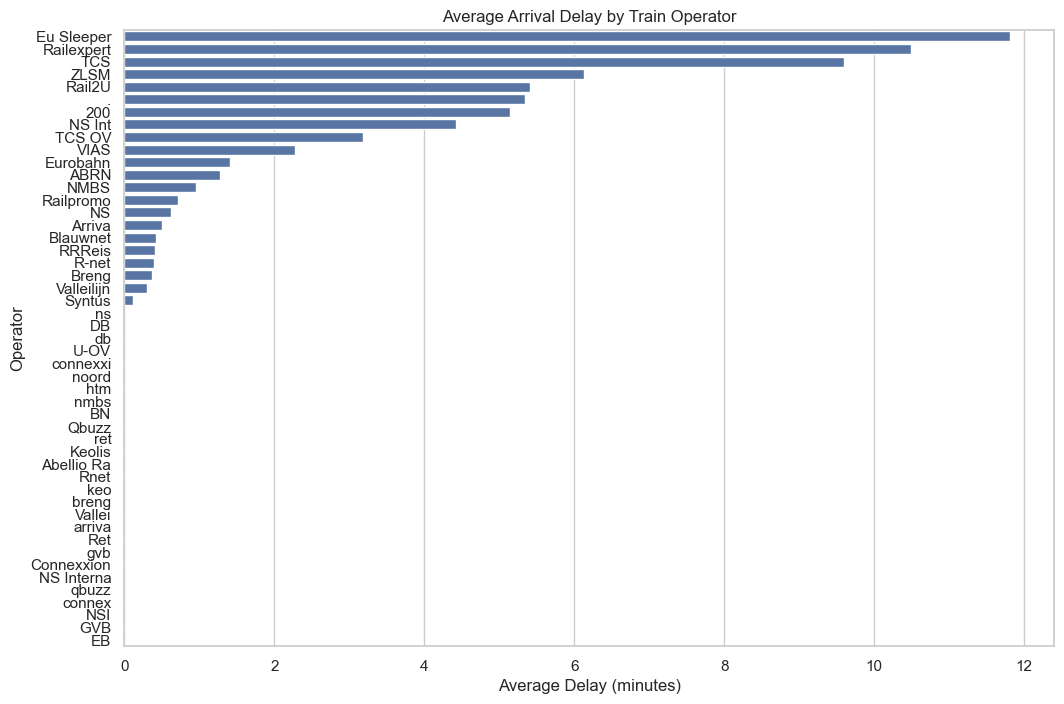

In [14]:
delay_by_operator_df = con.sql("""
SELECT "Service:Company",
       AVG(COALESCE("Stop:Arrival delay", 0)) AS avg_delay
FROM services
GROUP BY "Service:Company"
ORDER BY avg_delay DESC;
""").df()

plt.figure(figsize=(12, 8))
sns.barplot(data=delay_by_operator_df, x="avg_delay", y="Service:Company")
plt.title("Average Arrival Delay by Train Operator")
plt.xlabel("Average Delay (minutes)")
plt.ylabel("Operator")
plt.show()

### 7.8. Disruptions per Year (Plot)

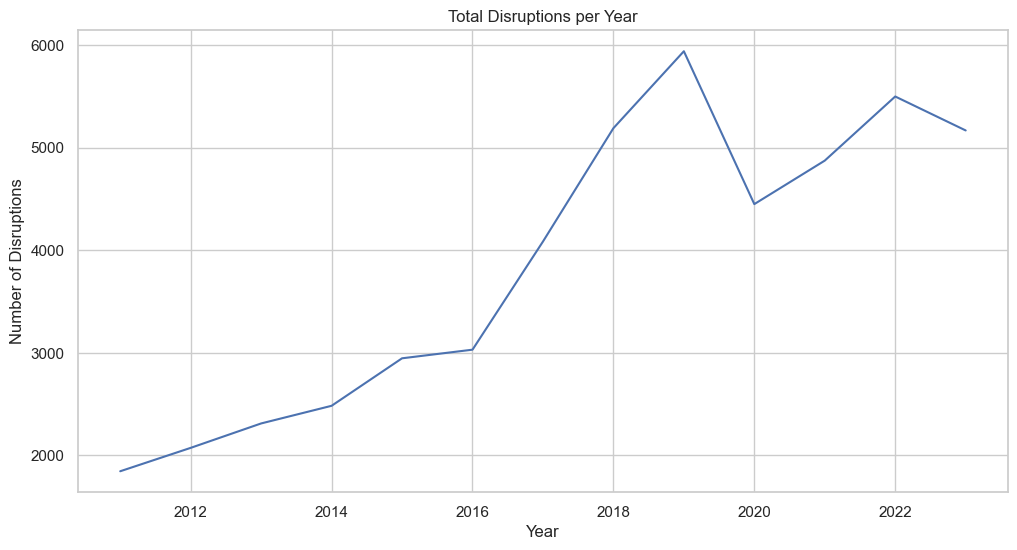

In [15]:
disruptions_by_year_df = con.sql("""
SELECT
    EXTRACT(YEAR FROM "start_time"::TIMESTAMP) AS disruption_year,
    COUNT(*) AS num_disruptions
FROM disruptions_db.disruptions
WHERE "start_time" IS NOT NULL
GROUP BY disruption_year
ORDER BY disruption_year;
""").df()

disruptions_by_year_df = disruptions_by_year_df.dropna(subset=["disruption_year"])
disruptions_by_year_df["disruption_year"] = disruptions_by_year_df[
    "disruption_year"
].astype(int)

plt.figure(figsize=(12, 6))
sns.lineplot(data=disruptions_by_year_df, x="disruption_year", y="num_disruptions")
plt.title("Total Disruptions per Year")
plt.xlabel("Year")
plt.ylabel("Number of Disruptions")
plt.show()

### 7.9. Cancellation Fraction by Year (Plot)

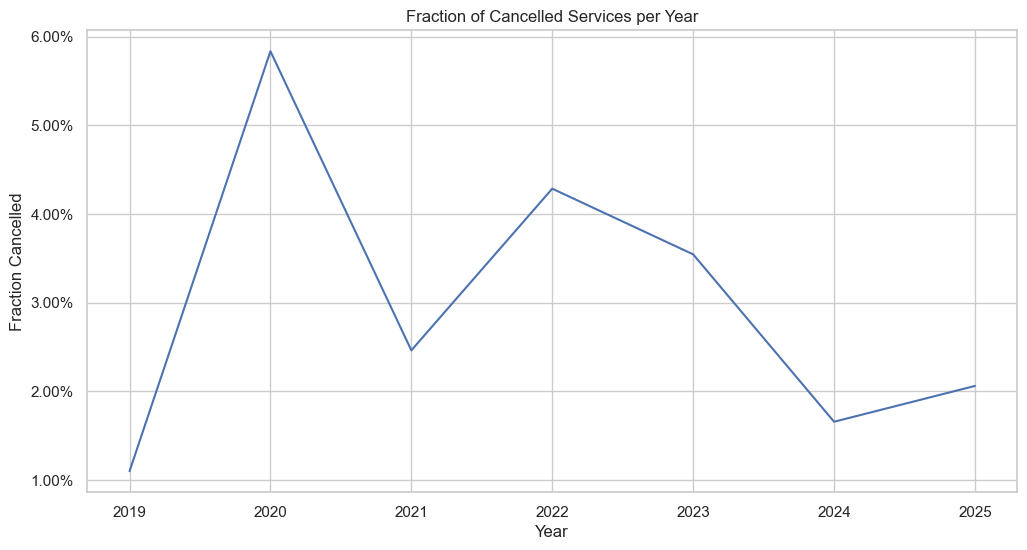

In [16]:
cancellations_by_year_df = con.sql("""
SELECT
    EXTRACT(YEAR FROM "Service:Date"::DATE) AS service_year,
    AVG(CASE WHEN "Service:Completely cancelled" THEN 1.0 ELSE 0.0 END) AS cancellation_fraction
FROM services
WHERE "Service:Date" IS NOT NULL
GROUP BY service_year
ORDER BY service_year;
""").df()


cancellations_by_year_df = cancellations_by_year_df.dropna(subset=["service_year"])
cancellations_by_year_df["service_year"] = cancellations_by_year_df[
    "service_year"
].astype(int)

plt.figure(figsize=(12, 6))
sns.lineplot(data=cancellations_by_year_df, x="service_year", y="cancellation_fraction")
plt.title("Fraction of Cancelled Services per Year")
plt.xlabel("Year")
plt.ylabel("Fraction Cancelled")
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter("{:.2%}".format))
plt.show()

## 8.1 & 8.2. Creating 'station_connections'

In [17]:
con.sql("""
CREATE OR REPLACE TABLE station_connections AS

SELECT DISTINCT
    pairs.start_station_code,
    pairs.end_station_code,
    dist.distance
FROM (
    SELECT
        "Stop:Station code" AS start_station_code,
        LEAD("Stop:Station code", 1) OVER (
            PARTITION BY "Service:RDT-ID"
            ORDER BY "Stop:Departure time" ASC NULLS LAST
        ) AS end_station_code
    FROM services
) AS pairs
JOIN distances_long AS dist
  ON pairs.start_station_code = dist.from_station_code
 AND pairs.end_station_code = dist.to_station_code
WHERE
    pairs.end_station_code IS NOT NULL;
""")


con.sql("SELECT * FROM station_connections LIMIT 10;").show()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌────────────────────┬──────────────────┬──────────┐
│ start_station_code │ end_station_code │ distance │
│      varchar       │     varchar      │  int64   │
├────────────────────┼──────────────────┼──────────┤
│ SRN                │ EC               │        5 │
│ HZE                │ MZ               │       10 │
│ EHV                │ HM               │       13 │
│ ASD                │ ASS              │        4 │
│ RSD                │ BGN              │       13 │
│ SDM                │ ZWD              │       22 │
│ TL                 │ TPSW             │        2 │
│ BRD                │ RLB              │        4 │
│ ZWD                │ DDR              │        2 │
│ RTZ                │ SDM              │        8 │
├────────────────────┴──────────────────┴──────────┤
│ 10 rows                                3 columns │
└──────────────────────────────────────────────────┘



## 8.3. Max Distance Between Connected Stations

In [18]:
con.sql("""
SELECT MAX(distance) AS max_connection_distance
FROM station_connections;
""").show()

┌─────────────────────────┐
│ max_connection_distance │
│          int64          │
├─────────────────────────┤
│                     421 │
└─────────────────────────┘



## 8.4. Histogram of Inter-station Distances (Plot)

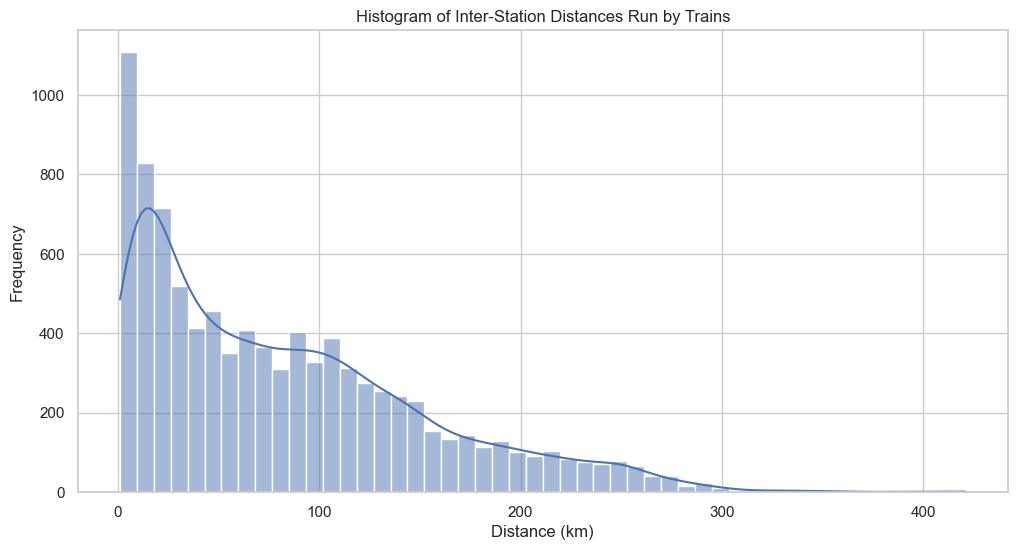

In [19]:
distances_df = con.sql(
    "SELECT distance FROM station_connections WHERE distance IS NOT NULL;"
).df()

plt.figure(figsize=(12, 6))
sns.histplot(distances_df["distance"], bins=50, kde=True)
plt.title("Histogram of Inter-Station Distances Run by Trains")
plt.xlabel("Distance (km)")
plt.ylabel("Frequency")
plt.show()


con.close()